# RealNVP (Real Non-Volume Preserving) Flows

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## Dataset

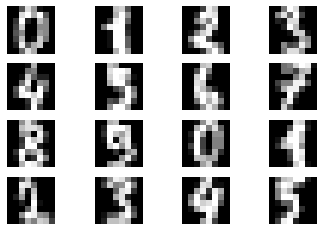

In [2]:
# Datasets
from sklearn import datasets

class Digits(Dataset):
  '''Digits in lower resolution'''
  def __init__(self, mode='train', transforms=None):
    digits = datasets.load_digits()
    if mode == 'train':
      self.data = digits.data[:1000].astype(np.float32)
    elif mode == 'val':
      self.data = digits.data[1000:1350].astype(np.float32)
    else:
      self.data = digits.data[1350:].astype(np.float32)
    
    self.transforms = transforms
    

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    sample = self.data[idx]
    if self.transforms:
      sample = self.transforms(sample)
    return sample

# Visualize the data
d = Digits('train')
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(d[i].reshape(8, 8), cmap='gray')
  plt.axis('off')

## Model

In [3]:
class RealNVP(nn.Module):
  '''
  Args:
  ----
    nets           [nn.Sequential]: scale network
    nett           [nn.Sequential]: translation network
    num_flows      [int]: number of flows
    prior          [torch.distribution]: distribution z comes from
    D              [int]: dimension of the data
    dequantization [bool]: discrete to continous transformation signal 
  '''
  def __init__(self, nets, nett, num_flows, prior, D=2, dequantization=True):
    super(RealNVP, self).__init__()
    
    self.dequantization = dequantization 
    self.prior = prior

    self.t = torch.nn.ModuleList([nett() for _ in range(num_flows)])
    self.s = torch.nn.ModuleList([nets() for _ in range(num_flows)])
    self.num_flows = num_flows

    self.D = D
  
  def coupling(self, x, index, forward=True):
    '''
    Args:
    ----
      x       [Tensor]: data of shape [batch, resolution]
      index   [int]:    indicator of the current flow indicator
      forward [bool]:   indicator of forward propagation (x to z) or inverse propagation (z to x)
    '''
    # Partition x
    (xa, xb) = torch.chunk(x, 2, 1)

    # Scale and Translation
    s = self.s[index](xa)
    t = self.t[index](xa)

    # Forward:  x to y
    if forward:
      # yb = f^{-1}(x)
      yb = (xb - t) * torch.exp(-s)
    
    # Inverse:  y to x
    else: 
      # xb = f(y)
      yb = torch.exp(s) * xb + t

    return torch.cat((xa, yb), 1), s

  def permute(self, x):
    '''
    Args:
    ----
    x [Tensor]: output of coupling layer
    '''
    return x.flip(1)
  
  def f(self, x):
    '''
    Definition:
    -----------
    Full forward propagation x to z: Coupling Layer + Permutation Layer
    
    Arg:
    ----
      x [Tensor]: data of shape [batch, resolution]
    
    Returns:
    --------
      z, log_det_J: latent vector and negative log determinant of Jacobian
    '''
    # Initialize log Jacobian determinant and z
    log_det_J, z = x.new_zeros(x.shape[0]), x
    for i in range(self.num_flows):
      z, s = self.coupling(z, i, forward=True)
      z = self.permute(z)
      log_det_J = log_det_J - s.sum(dim=1)
    
    return z, log_det_J

  def f_inv(self, z):
    '''
    Definition:
    -----------
    Full inverse propagation z to x

    Arg:
    ----
      z [Tensor]: latent vector
    
    Returns:
    --------
      x [Tensor]: sample feature map
    '''
    # Initialize output feature map x
    x = z
    for i in reversed(range(self.num_flows)):
      x = self.permute(x)
      x, _ = self.coupling(x, i, forward=False)
    
    return x

  def forward(self, x, reduction='avg'):
    z, log_det_J = self.f(x)
    if reduction == 'sum':
      return -(self.prior.log_prob(z) + log_det_J).sum()
    else:
      return -(self.prior.log_prob(z) + log_det_J).mean()
    
  def sample(self, batch_size):
    z = self.prior.sample((batch_size, self.D))
    z = z[:, 0, :]
    x = self.f_inv(z)
    return x.view(-1, self.D)


## Auxilary Functions: Training, Evaluation, Plotting

In [4]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
  if model_best is None:
    # Load the best performing model
    model_best = torch.load(name + '.model')
  
  # Evaluation mode
  model_best.eval()

  # Initialize loss and number of number of data points
  loss, N = 0.0, 0

  for batch_idx, test_batch in enumerate(test_loader):
    if hasattr(model_best, 'dequantization'):
      if model_best.dequantization:
        test_batch = test_batch + (1 - torch.rand(test_batch.shape))/2
    
    loss_t = model_best.forward(test_batch, reduction='sum')
    loss = loss + loss_t.item()
    N = N + test_batch.shape[0]
  
  loss = loss / N

  if epoch is None:
    print(f'Final Loss: nll = {loss}')
  else:
    print(f'Epoch: {epoch}, val nll = {loss}')
  
  return loss

In [5]:
def samples_real(name, test_loader):
  num_x = 4
  num_y = 4
  x = next(iter(test_loader)).detach().numpy()

  fig, ax = plt.subplots(num_x, num_y)
  for i, ax in enumerate(ax.flatten()):
    img = np.reshape(x[i], (8, 8))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
  
  plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
  plt.close()

In [6]:
def samples_generated(name, data_loader, extra_name=''):
  # Get data
  x = next(iter(data_loader)).detach().numpy()

  # Get best model
  model_best = torch.load(name+'.model')
  model_best.eval()

  # Generation
  num_x = 4
  num_y = 4
  x = model_best.sample(num_x * num_y)
  x = x.detach().numpy()

  # Visualize
  fig, ax = plt.subplots(num_x, num_y)
  for i, ax in enumerate(ax.flatten()):
    img = np.reshape(x[i], (8, 8))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
  
  # Save
  plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
  plt.close()


In [7]:
def plot_curve(name, nll_val):
  plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
  plt.xlabel('epochs')
  plt.ylabel('nll')
  plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
  plt.close()

In [8]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
  # Initialize
  nll_val = []
  best_nll = float('inf')
  patience = 0

  # Training Loop
  for e in range(num_epochs):
    model.train()
    for batch_idx, batch in enumerate(training_loader):
      if hasattr(model, 'dequantization'):
        if model.dequantization:
          batch = batch + (1. - torch.rand(batch.shape))/2
      
      loss = model.forward(batch)
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
    
    # Validation
    loss_val = evaluation(val_loader, model_best=model, epoch=e)
    nll_val.append(loss_val)

    if e == 0:
      print('Saved!')
      torch.save(model, name + '.model')
      best_nll = loss_val
    else:
      if loss_val < best_nll:
        print('Saved!')
        torch.save(model, name + '.model')
        best_nll = loss_val
        patience = 0

        samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
      else:
        patience = patience + 1
    
    if patience > max_patience:
      break
  
  nll_val = np.asarray(nll_val)
  return nll_val

In [9]:
deneme = torch.rand(10000)
deneme.min(), deneme.max()

(tensor(5.8413e-06), tensor(0.9997))

In [10]:
deneme = deneme + (1. - torch.rand(deneme.shape))/2.
deneme.min(), deneme.max()

(tensor(0.0047), tensor(1.4873))

## Dataloader

In [11]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'realnvp'

## Hyperparameters

In [12]:
D = 64   # input dimension
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

## Initialize RealNVP

In [13]:
# The number of invertible transformations
num_flows = 8

# scale (s) network
nets = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                             nn.Linear(M, M), nn.LeakyReLU(),
                             nn.Linear(M, D // 2), nn.Tanh())

# translation (t) network
nett = lambda: nn.Sequential(nn.Linear(D // 2, M), nn.LeakyReLU(),
                             nn.Linear(M, M), nn.LeakyReLU(),
                             nn.Linear(M, D // 2))

# Prior (base distribution): Gaussian
prior = torch.distributions.MultivariateNormal(torch.zeros(D), torch.eye(D))

# Init RealNVP
model = RealNVP(nets, nett, num_flows, prior, D=D, dequantization=True)

In [14]:
# Optimizer
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

In [15]:
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, val nll = 273.96423270089286
Saved!
Epoch: 1, val nll = 231.4692368861607
Saved!
Epoch: 2, val nll = 215.71248604910716
Saved!
Epoch: 3, val nll = 206.21343610491073
Saved!
Epoch: 4, val nll = 198.672529296875
Saved!
Epoch: 5, val nll = 192.53224051339285
Saved!
Epoch: 6, val nll = 187.20795200892857
Saved!
Epoch: 7, val nll = 182.743017578125
Saved!
Epoch: 8, val nll = 179.28142857142856
Saved!
Epoch: 9, val nll = 176.28331194196429
Saved!
Epoch: 10, val nll = 173.81815150669644
Saved!
Epoch: 11, val nll = 171.81197684151786
Saved!
Epoch: 12, val nll = 169.65369838169642
Saved!
Epoch: 13, val nll = 168.07443080357143
Saved!
Epoch: 14, val nll = 166.46301199776786
Saved!
Epoch: 15, val nll = 164.9895103236607
Saved!
Epoch: 16, val nll = 163.78516741071428
Saved!
Epoch: 17, val nll = 162.82151506696428
Saved!
Epoch: 18, val nll = 161.57569056919644
Saved!
Epoch: 19, val nll = 160.78778041294643
Saved!
Epoch: 20, val nll = 159.96385184151785
Saved!
Epoch: 21, val nll = 159.4851

In [16]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

Final Loss: nll = 140.4887575153803
